### 時系列

記事URL

理論編  
https://logics-of-blue.com/%E6%99%82%E7%B3%BB%E5%88%97%E8%A7%A3%E6%9E%90_%E7%90%86%E8%AB%96%E7%B7%A8/

実践編  
https://logics-of-blue.com/%E6%99%82%E7%B3%BB%E5%88%97%E5%88%86%E6%9E%90_%E5%AE%9F%E8%B7%B5%E7%B7%A8/

https://logics-of-blue.com/python-time-series-analysis/

In [52]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as SNS 

from scipy import stats
import statsmodels.api as sm

In [54]:
# df = pd.read_csv('./data_time_series/AirPassengers.csv').set_index('Month')
data = pd.read_csv('./data_time_series/AirPassengers.csv', 
                   index_col='Month', 
                   parse_dates=True, 
                   dtype='float')
data.head()

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [55]:
ts = data['#Passengers']

### 時系列データ観察

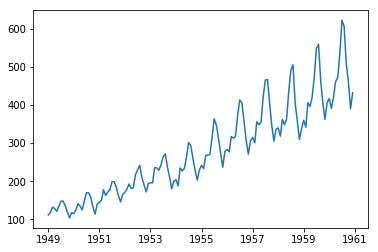

In [56]:
plt.plot(ts)

・乗客数が年々増えているということ。  
・季節ごとに乗客数が周期的に変わりそうだということ。  


In [57]:
diff = ts - ts.shift()

In [58]:
logDiff = np.log(ts) - np.log(ts.shift())

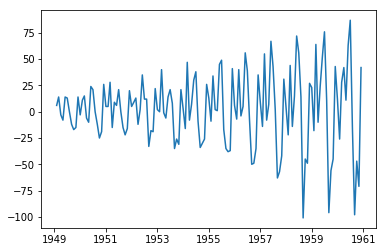

In [59]:
plt.plot(diff)

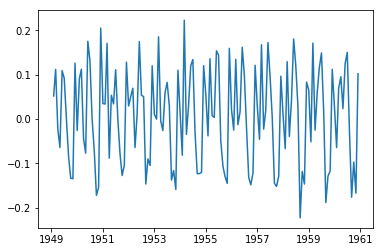

In [60]:
plt.plot(logDiff)

### 自己相関係数の推定

自己相関、前期と今期は似ているかどうか  
偏自己相関、期とは関係ない

In [61]:
ts_acf = sm.tsa.stattools.acf(ts,nlags=40)
ts_acf

array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542,
       0.71376997, 0.6817336 , 0.66290439, 0.65561048, 0.67094833,
       0.70271992, 0.74324019, 0.76039504, 0.71266087, 0.64634228,
       0.58592342, 0.53795519, 0.49974753, 0.46873401, 0.44987066,
       0.4416288 , 0.45722376, 0.48248203, 0.51712699, 0.53218983,
       0.49397569, 0.43772134, 0.3876029 , 0.34802503, 0.31498388,
       0.28849682, 0.27080187, 0.26429011, 0.27679934, 0.2985215 ,
       0.32558712, 0.3370236 , 0.30333486, 0.25397708, 0.21065534,
       0.17217092])

偏自己相関

In [62]:
ts_pacf = sm.tsa.stattools.pacf(ts, nlags=40, method='ols')
ts_pacf

array([ 1.        ,  0.95893198, -0.32983096,  0.2018249 ,  0.14500798,
        0.25848232, -0.02690283,  0.20433019,  0.15607896,  0.56860841,
        0.29256358,  0.8402143 ,  0.61268285, -0.66597616, -0.38463943,
        0.0787466 , -0.02663483, -0.05805221, -0.04350748,  0.27732556,
       -0.04046447,  0.13739883,  0.3859958 ,  0.24203808, -0.04912986,
       -0.19599778, -0.15443575,  0.04484465,  0.18371541, -0.0906113 ,
       -0.06202938,  0.34827092,  0.09899499, -0.08396793,  0.36328898,
       -0.17956662,  0.15839435,  0.06376775, -0.27503705,  0.2707607 ,
        0.32002003])

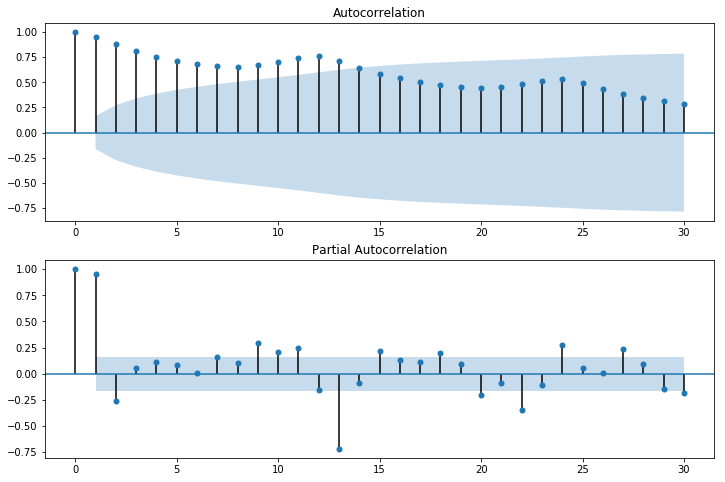

In [63]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
fig = sm.graphics.tsa.plot_acf(ts,lags = 30,ax = ax1)
ax2 = fig.add_subplot(2,1,2)
fig = sm.graphics.tsa.plot_pacf(ts, lags=30, ax=ax2)

1か月後と12か月後が著しい  
1、前月が多ければ今月も多い  
2、去年のこの月が多ければ、来年も多い

### ARIMAモデルによる推定

差分を取る理由  
今回は和分過程、差分を取って解析します。  



和分過程に対して、普通の自己回帰モデルなどを適用する際に「定常過程のモデルを推定しなければならない → enforce_stationarity = True」を指定していると、そもそもモデルが推定できませんね。  


普通は和分過程を相手にする場合は、必ず差分をとってから自己回帰モデルを適用するのですが、  
今回は次数を総当たりで変えているため、「和分過程に自己回帰モデルを適用する」という計算が行われてしまいます。

In [64]:
diff = ts - ts.shift()
diff = diff.dropna()

In [65]:
resDiff = sm.tsa.arma_order_select_ic(diff , ic = 'aic',trend = 'nc')
resDiff

{'aic':              0            1            2
 0          NaN  1397.257791  1397.093436
 1  1401.852641  1412.615224  1385.496795
 2  1396.587654  1378.338024  1353.175734
 3  1395.021214  1379.614000  1351.138710
 4  1388.216680  1379.616584  1373.560615, 'aic_min_order': (3, 2)}

aic_min_order': (3, 2)　が重要みたい  
ARMA（3,2）  
3次と2次相関を取る  

3がARモデルの次数、2がMAモデルの次数  

In [66]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

ARIMA_3_1_2 = ARIMA(ts,order = (3,1,2)).fit(disp = False)
print(ARIMA_3_1_2.params)

ARMA_3_1_2 = ARMA(ts,order = (3,2)).fit(disp = False)
print(ARMA_3_1_2.params)


const                  2.673504
ar.L1.D.#Passengers    0.261991
ar.L2.D.#Passengers    0.367830
ar.L3.D.#Passengers   -0.363472
ma.L1.D.#Passengers   -0.075064
ma.L2.D.#Passengers   -0.924862
dtype: float64
const                280.621572
ar.L1.#Passengers      2.663905
ar.L2.#Passengers     -2.587858
ar.L3.#Passengers      0.923953
ma.L1.#Passengers     -1.848685
ma.L2.#Passengers      0.947576
dtype: float64


真ん中のorderは何だろう

残差の自己相関を見る

In [67]:
#残差
resid = ARIMA_3_1_2.resid
resid2 = ARMA_3_1_2.resid


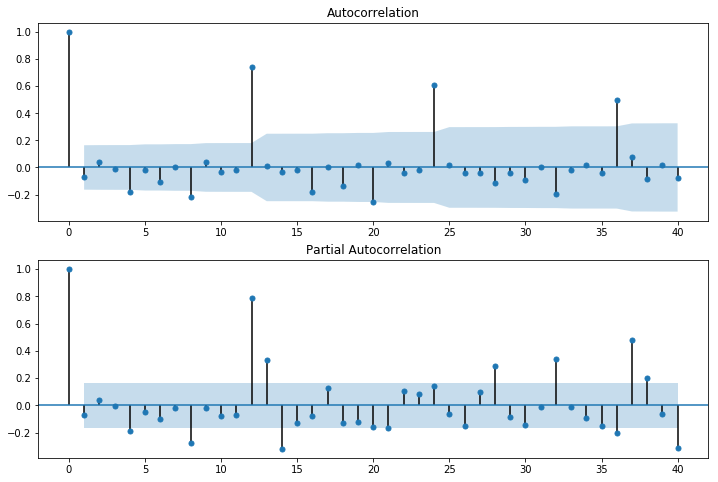

In [68]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

1年ごとに高くなる、残差が

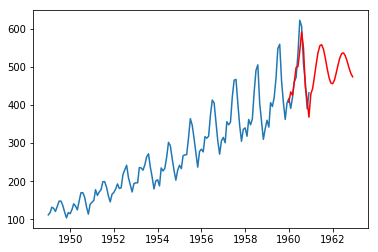

In [69]:
# 予測
pred = ARMA_3_1_2.predict('1960-01-01', '1962-12-01')

# 実データと予測結果の図示
plt.plot(ts)
plt.plot(pred, "r")

予測は大体オッケーですが、上下変動の幅はだめです。  
より長期的に予測するとダメになっちゃう

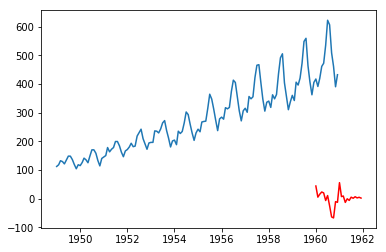

In [70]:
# 予測
pred = ARIMA_3_1_2.predict('1960-01-01', '1961-12-01')

# 実データと予測結果の図示
plt.plot(ts)
plt.plot(pred, "r")

赤いやつはあくまでも差分の予測

### SARIMA 季節性も含めて考える

In [71]:
import statsmodels.api as sm
#order=(3,1,2)でARIMAモデルの次数を、seasonal_order=(1,1,1,12)で季節変動の次数を設定します。
#seasonal_order=(1,1,1,12)の最後の「12」は「12か月周期」であることを意味しています。なので、実質は(sp,sd,sq)=(1,1,1)です。
SARIMA_3_1_2_111 = sm.tsa.SARIMAX(ts, order=(3,1,2), seasonal_order=(1,1,1,12)).fit()
print(SARIMA_3_1_2_111.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(3, 1, 2)x(1, 1, 1, 12)   Log Likelihood                -502.967
Date:                            Wed, 12 Dec 2018   AIC                           1021.934
Time:                                    11:30:14   BIC                           1044.935
Sample:                                01-01-1949   HQIC                          1031.280
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6707      1.520      0.441      0.659      -2.308       3.649
ar.L2          0.2093      0.902   

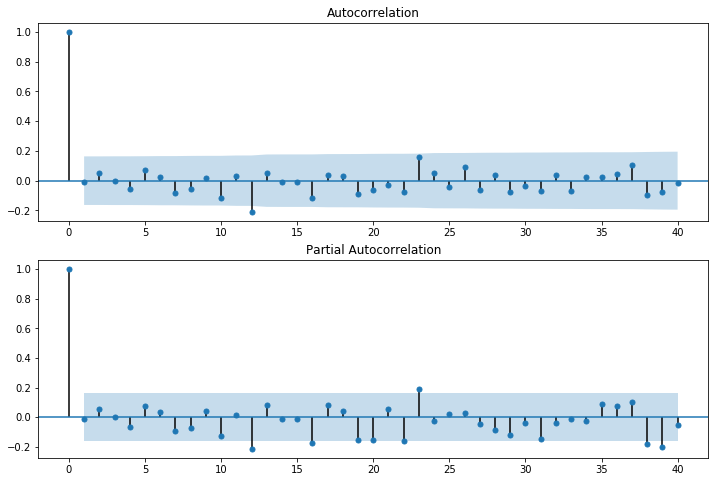

In [72]:
# 残差のチェック
residSARIMA = SARIMA_3_1_2_111.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=40, ax=ax2)

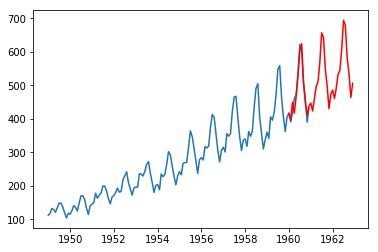

In [73]:
# 予測
pred = SARIMA_3_1_2_111.predict('1960-01-01', '1962-12-01')

# 実データと予測結果の図示
plt.plot(ts)
plt.plot(pred, "r")